In [1]:
import requests
from requests.exceptions import HTTPError
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from pathlib import Path


In [2]:
conteudo = None
URL = 'https://finance.yahoo.com/crypto/'

try:
    resposta = requests.get(URL)
    resposta.raise_for_status()
except HTTPError as exc:
    print(exc)
else:
    conteudo = resposta.text

In [3]:
pagina = BeautifulSoup(conteudo, 'html.parser')

tabela = pagina.find('table')
if tabela is not None:
    cabecalho = [th.get_text() for th in tabela.find_all('th')]
    linhas = tabela.find_all('tr')
    dados = []

    for linha in linhas[1:]:
        valores = [re.sub(r'\s+', ' ', td.get_text().strip()) for td in linha.find_all('td')]
        dados.append(valores)

    yahoo_crypto_df = pd.DataFrame(dados, columns=cabecalho)
    yahoo_crypto_df.replace(to_replace=[r'\$', r'\%'], value='', regex=True, inplace=True)

    # Comentando a linha de salvamento do arquivo CSV
    arquivo_csv = Path.cwd() / 'yahoo_crypto-limpo.csv'
    yahoo_crypto_df.to_csv(arquivo_csv, mode='w', encoding='utf8', sep=';', index=False)

    # Imprimir o DataFrame diretamente no console
    print(yahoo_crypto_df)

    print("Dados impressos com sucesso!")
else:
    print("Tabela não encontrada na página HTML.")

          Symbol                 Name Price (Intraday)       Change % Change  \
0        BTC-USD          Bitcoin USD        29,045.58        +1.97    +0.01   
1        ETH-USD         Ethereum USD         1,817.86       -11.60    -0.63   
2       USDT-USD      Tether USDt USD         0.998883    +0.000424    +0.04   
3        BNB-USD              BNB USD           240.87        -2.17    -0.89   
4        XRP-USD              XRP USD         0.613458    -0.013215    -2.11   
5       USDC-USD         USD Coin USD         0.999953    +0.000168    +0.02   
6      STETH-USD  Lido Staked ETH USD         1,813.72       -13.48    -0.74   
7       DOGE-USD         Dogecoin USD         0.073024    -0.001799    -2.40   
8        ADA-USD          Cardano USD         0.287491    -0.004176    -1.43   
9        SOL-USD           Solana USD            22.78        -0.43    -1.86   
10      WTRX-USD     Wrapped TRON USD         0.076341    -0.000524    -0.68   
11       TRX-USD             TRON USD   

In [4]:
# %% Trantando os dados das colunas
yahoo_crypto_df.rename(columns={'Symbol': 'symbol'}, inplace=True)
yahoo_crypto_df.rename(columns={'Name': 'name'}, inplace=True)
yahoo_crypto_df.rename(columns={'Price (Intraday)': 'price_day'}, inplace=True)
yahoo_crypto_df.rename(columns={'Change': 'change'}, inplace=True)
yahoo_crypto_df.rename(columns={'% Change': 'change_percent'}, inplace=True)
yahoo_crypto_df.rename(columns={'Market Cap': 'market_value'}, inplace=True)
yahoo_crypto_df.rename(columns={'Volume in Currency (24Hr)': 'volume_currency_24h'}, inplace=True)
yahoo_crypto_df.rename(columns={'Total Volume All Currencies (24Hr)': 'total_volume_currency_24h'}, inplace=True)
yahoo_crypto_df.rename(columns={'Circulating Supply': 'circulating_supply'}, inplace=True)

yahoo_crypto_df.drop(columns = ['Volume in Currency (Since 0:00 UTC)'], inplace=True)
yahoo_crypto_df.drop(columns = ['52 Week Range'], inplace=True)
yahoo_crypto_df.drop(columns = ['Day Chart'], inplace=True)

yahoo_crypto_df['price_day'] = yahoo_crypto_df['price_day'].str.replace(',', '')  # Remover a vírgula
yahoo_crypto_df['price_day'] = yahoo_crypto_df['price_day'].astype(float) #Converte para float
yahoo_crypto_df['change_percent'] = pd.to_numeric(yahoo_crypto_df['change_percent'], errors='coerce')  #Converte para valores numéricos

#Filtrando por criptomoedas que apresentem mudanças percentuais positivas no dia
filtered_df = yahoo_crypto_df.query('change_percent > 0.00')

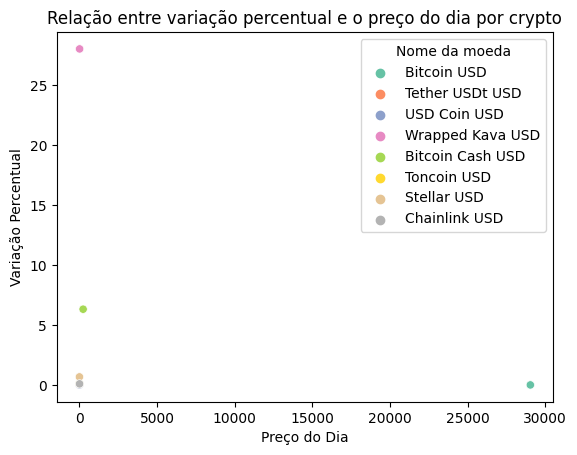

In [12]:
# Plotar o gráfico de dispersão com a escala de cores aplicada pela coluna "change_percent"
sns.scatterplot(data=filtered_df, x="price_day", y="change_percent", hue="name", palette="Set2", alpha=1.0)

# Adicionar rótulos aos eixos
plt.title("Relação entre variação percentual e o preço do dia por crypto")
plt.xlabel('Preço do Dia')
plt.ylabel('Variação Percentual')
plt.legend(title="Nome da moeda")